<a href="https://colab.research.google.com/github/nerbivol/siamese_damage_detection/blob/main/model_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.4/595.4 kB 25.9 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt
import random
import glob

import cv2
import numpy as np
from ultralytics import YOLO

import torch
import tensorflow as tf

In [ ]:
# checking availability of GPU resources
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.0.1+cu118 (CPU)


In [ ]:
from pathlib import Path

base_path = "/content/drive/MyDrive/Colab Notebooks"

os.chdir(f'{base_path}')

folder_name = "DamageBuilding"
Path(f'{base_path}/{folder_name}').mkdir(parents=True, exist_ok=True)
os.chdir(f'{base_path}/{folder_name}')

!pwd

!ls

/content/drive/MyDrive/Colab Notebooks/DamageBuilding
annotations.csv		     PostImages		     valid
clasify			     preprocess.ipynb	     yolov8n.pt
Damage_classification.ipynb  runs		     yolov8s.pt
Damage_YOLOv8.ipynb	     Siamese_classify.ipynb
data.yaml		     train


In [ ]:
detect_model = YOLO("runs/detect/train6/weights/best.pt")
classify_name = "20230608-062743/model_20230608-062743_014_0.7642.h5"
MODEL_PATH = f"clasify/model-checkpts/{classify_name}"
classify_model = tf.keras.models.load_model(MODEL_PATH)

In [ ]:
def class_predict(pre_image , post_image):
  pre_image = tf.image.resize(pre_image, (64, 64))[None, :]
  pre_image = tf.image.per_image_standardization(pre_image)

  post_image = tf.image.resize(post_image, (64, 64))[None, :]
  post_image = tf.image.per_image_standardization(post_image)

  pred = classify_model.predict([pre_image, post_image])
  return np.argmax(pred)

In [ ]:
# Color codes for bounding boxs
damage_dict = {
    0: (0, 255, 0),
    1:(255, 255, 102),
    2: (255, 153, 51),
    3: (255, 0, 0)
}

In [ ]:
def plot_images_with_boxes(image_file, result):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(30, 15))
    
    annotation_path = image_file.replace('images', 'labels').replace('jpg', 'txt')
    print(annotation_path)
    pre_image = image_file.replace('post', 'pre')

    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pre_image = cv2.imread(pre_image)
    pre_image = cv2.cvtColor(pre_image, cv2.COLOR_BGR2RGB)

    with open(annotation_path, "r") as f:
        annotations = f.readlines()

    ax1.imshow(pre_image)
    ax1.set_title('Pre image', fontsize=24)

    ax2.imshow(image)
    ax2.set_title('Post image', fontsize=24)

    image_predict = image.copy()

    for annotation in annotations:
        class_id, x, y, width, height = map(float, annotation.split())
        left = int((x - width / 2) * image.shape[1])
        top = int((y - height / 2) * image.shape[0])
        right = int((x + width / 2) * image.shape[1])
        bottom = int((y + height / 2) * image.shape[0])

        cv2.rectangle(image, (left, top), (right, bottom), damage_dict[int(class_id)], 2)

    ax3.imshow(image)
    ax3.set_title('True label', fontsize=24)

    for box in result[0].boxes:
      left, bottom, right, top = map(int, box.xyxy[0])
      # print(f"{right-left}, {top-bottom} px")
      class_id = class_predict(pre_image[left:right, bottom:top], image[left:right, bottom:top])

      cv2.rectangle(image_predict, (left, bottom), (right, top), damage_dict[int(class_id)], 2)

    ax4.imshow(image_predict)
    ax4.set_title('Predict label', fontsize=24)

    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    plt.show()

In [ ]:
image_path = 'PostImages/images'
label_path = 'PostImages/labels'

pre_images = sorted(glob.glob(os.path.join(image_path, "*pre*")))
post_images = sorted(glob.glob(os.path.join(image_path, "*post*")))

# pre_label = sorted(glob.glob(os.path.join(label_path, "*pre*")))
# post_label = sorted(glob.glob(os.path.join(label_path, "*post*")))



image 1/1 /content/drive/MyDrive/Colab Notebooks/DamageBuilding/PostImages/images/socal-fire_00000899_post_0_1.jpg: 512x512 6 roofs, 455.7ms
Speed: 1.8ms preprocess, 455.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict2


PostImages/labels/socal-fire_00000899_post_0_1.txt
1/1 [==============================] - 0s 221ms/step


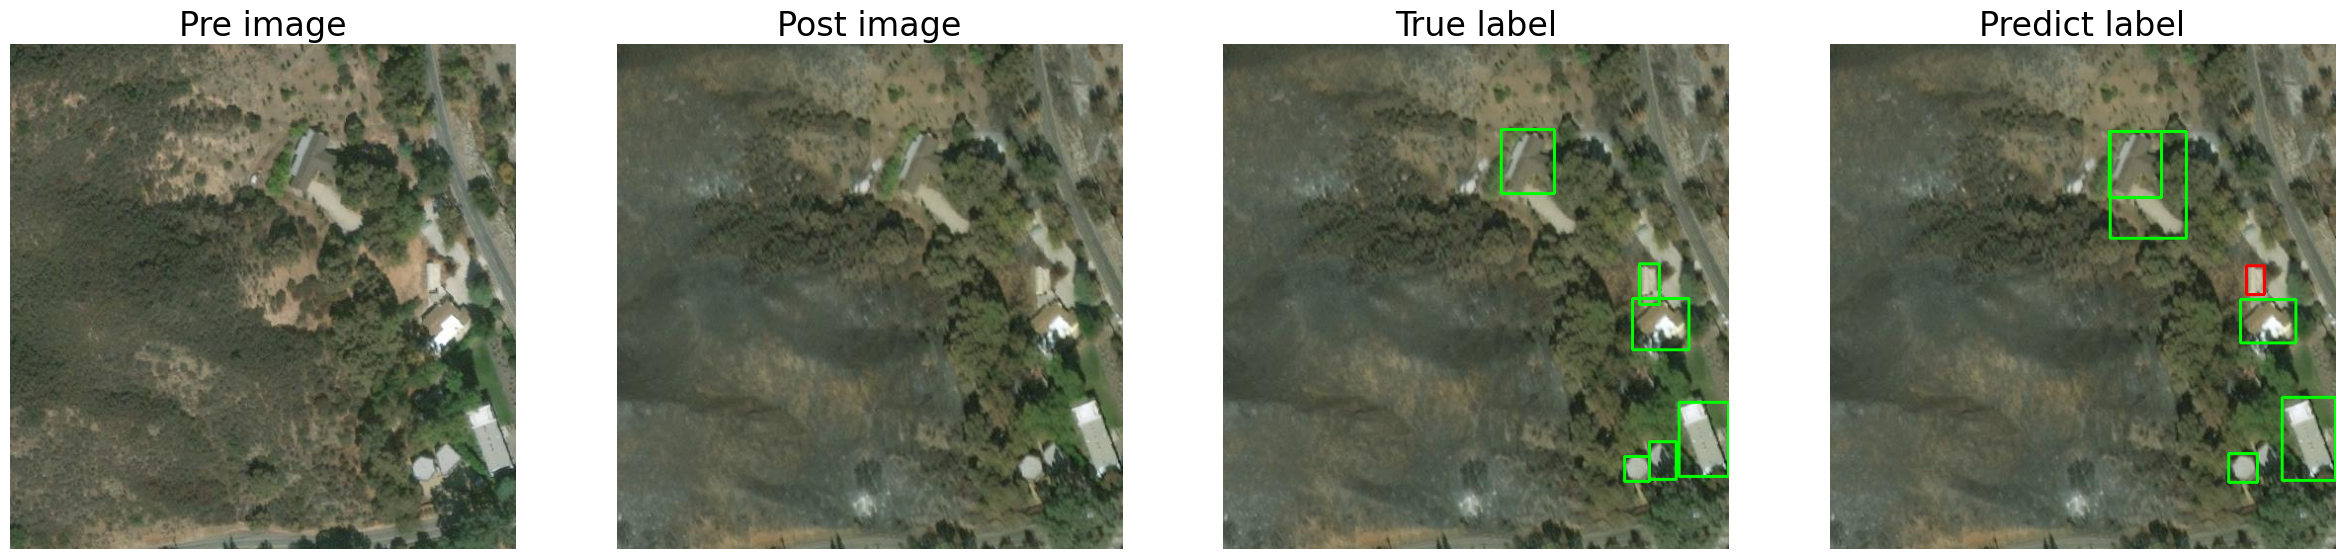


image 1/1 /content/drive/MyDrive/Colab Notebooks/DamageBuilding/PostImages/images/santa-rosa-wildfire_00000316_post_0_0.jpg: 512x512 60 roofs, 392.0ms
Speed: 1.7ms preprocess, 392.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict2


PostImages/labels/santa-rosa-wildfire_00000316_post_0_0.txt
1/1 [==============================] - 0s 235ms/step


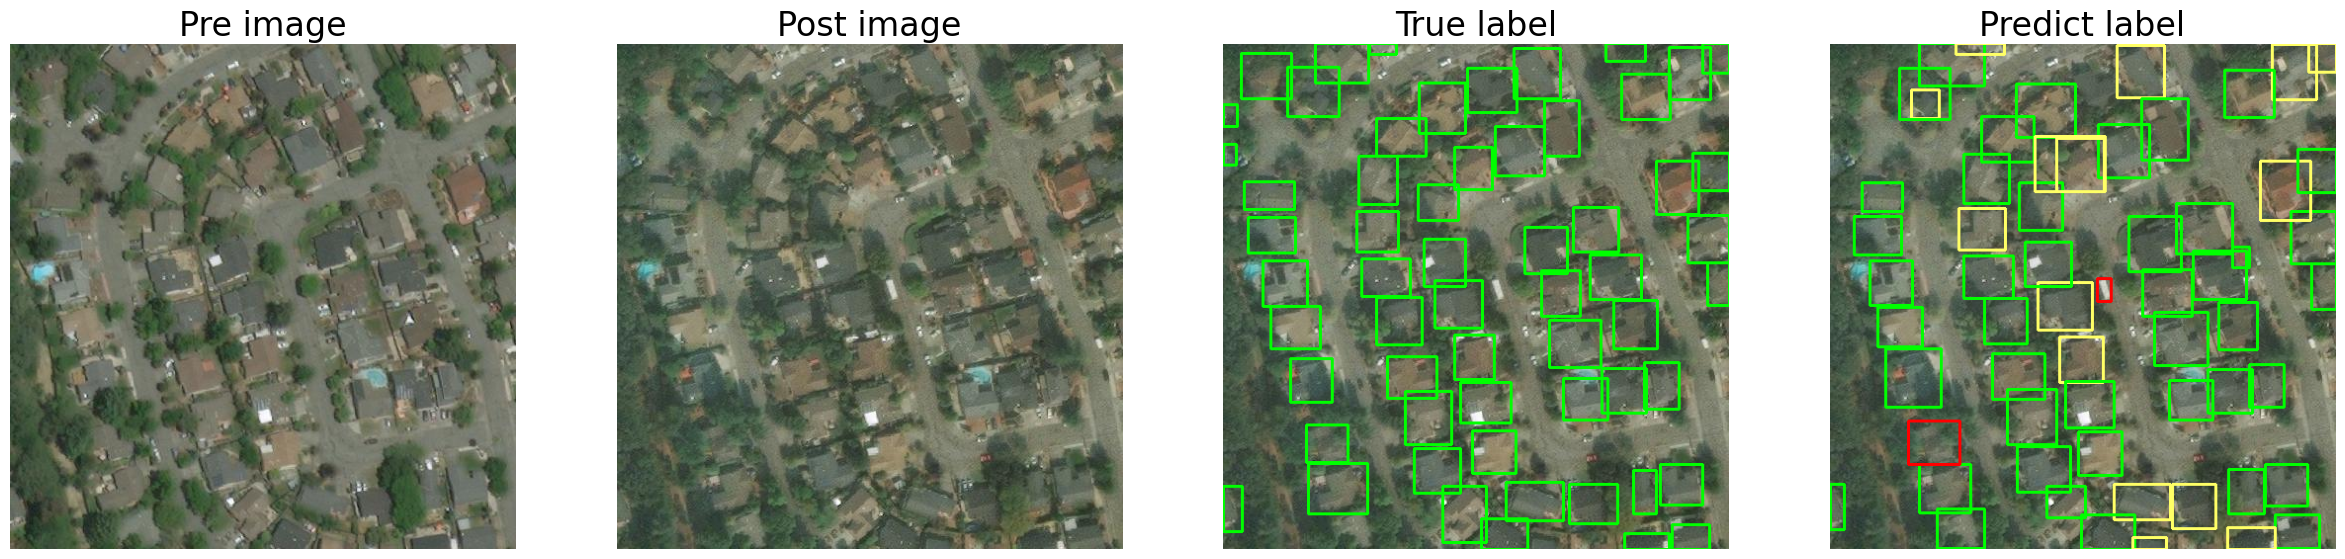


image 1/1 /content/drive/MyDrive/Colab Notebooks/DamageBuilding/PostImages/images/mexico-earthquake_00000085_post_1_0.jpg: 512x512 64 roofs, 392.6ms
Speed: 1.7ms preprocess, 392.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict2


PostImages/labels/mexico-earthquake_00000085_post_1_0.txt
1/1 [==============================] - 0s 127ms/step


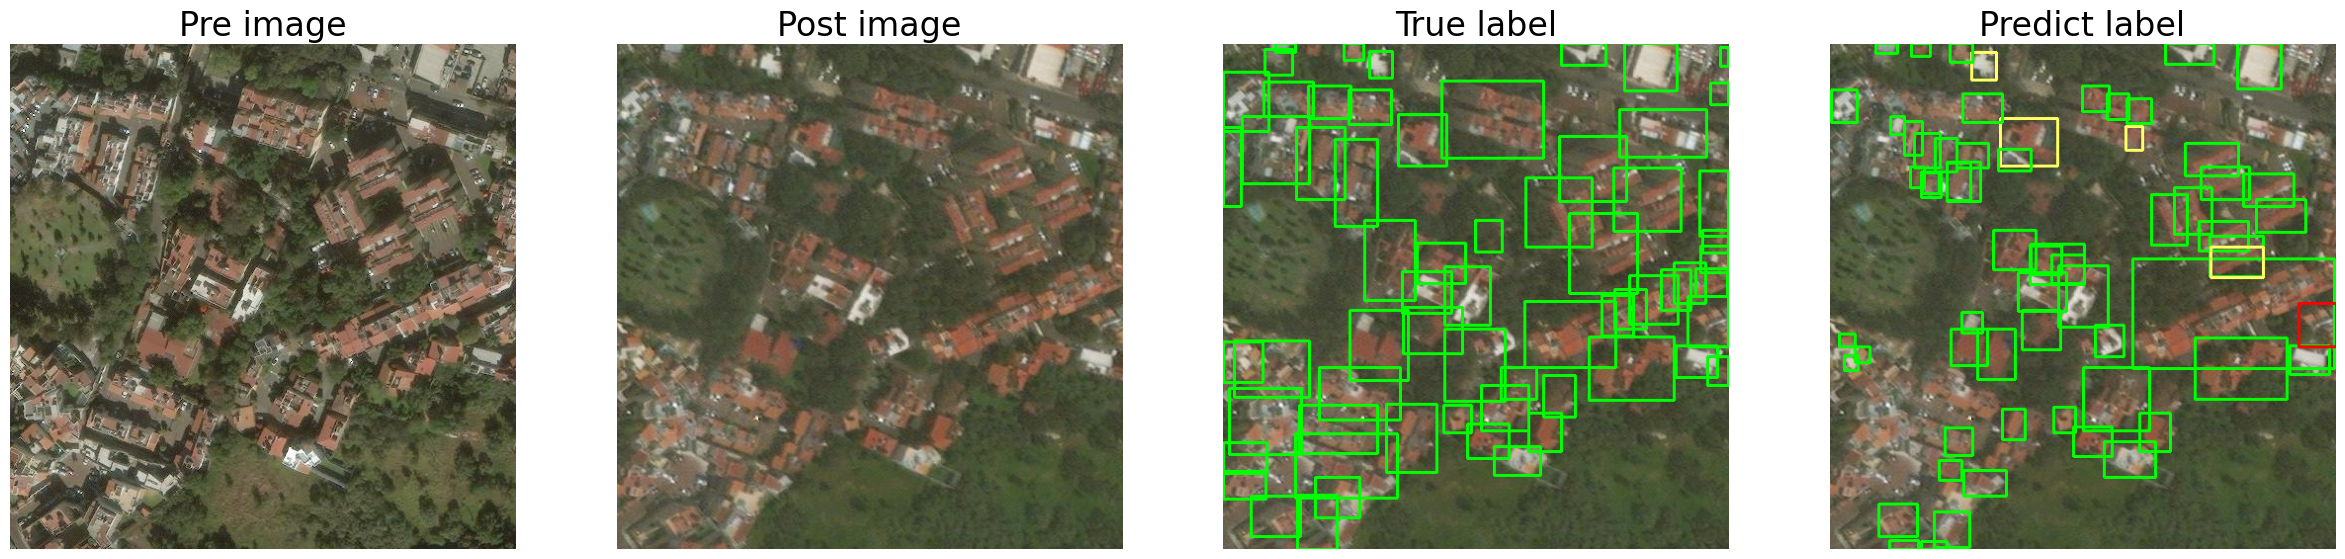


image 1/1 /content/drive/MyDrive/Colab Notebooks/DamageBuilding/PostImages/images/socal-fire_00000469_post_1_0.jpg: 512x512 2 roofs, 404.9ms
Speed: 1.7ms preprocess, 404.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict2


PostImages/labels/socal-fire_00000469_post_1_0.txt
1/1 [==============================] - 0s 139ms/step


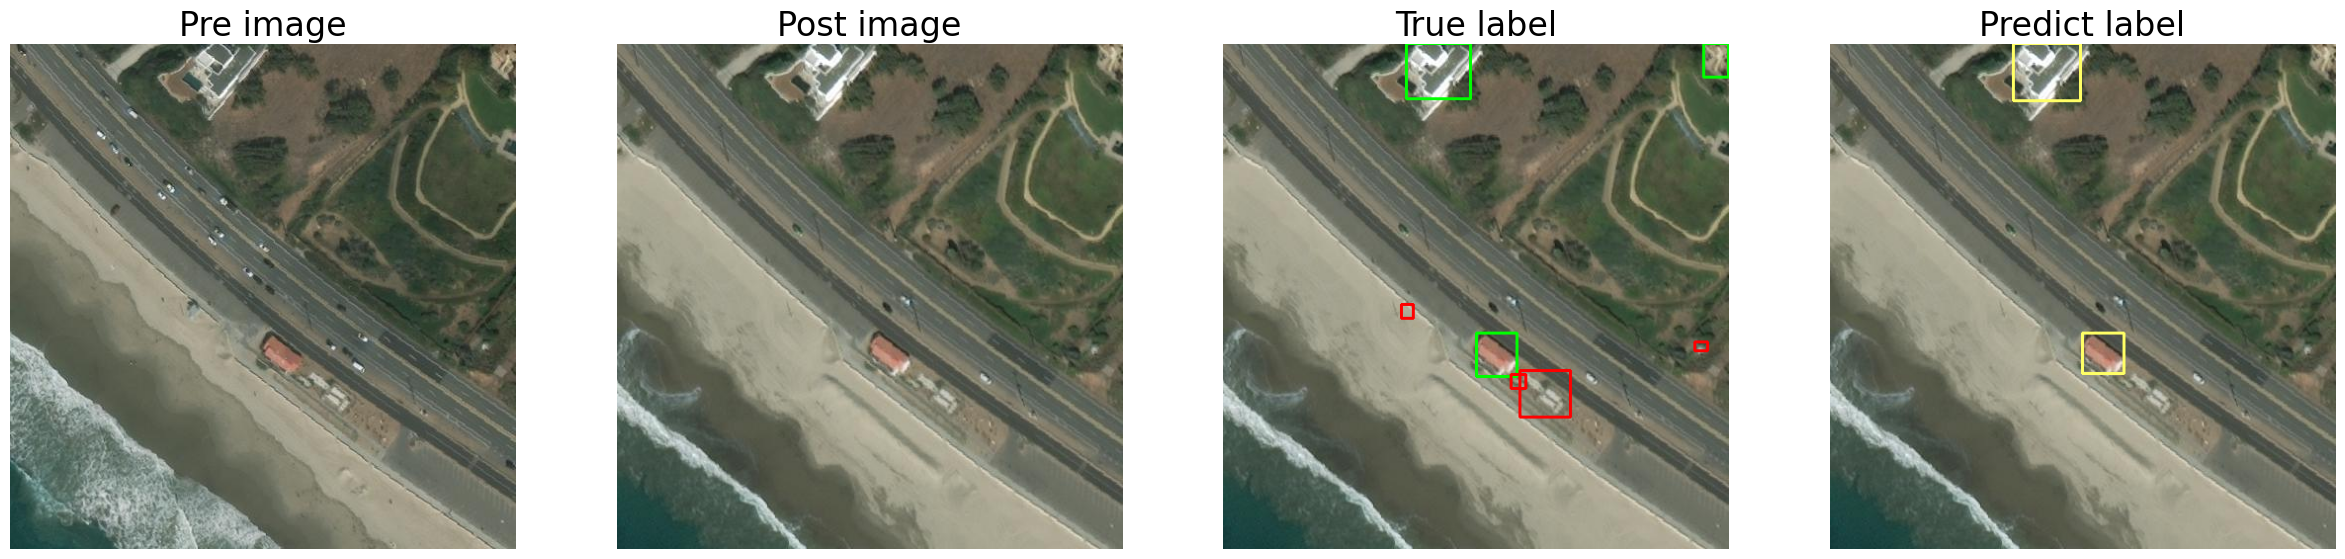


image 1/1 /content/drive/MyDrive/Colab Notebooks/DamageBuilding/PostImages/images/socal-fire_00000296_post_1_0.jpg: 512x512 6 roofs, 394.5ms
Speed: 1.7ms preprocess, 394.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict2


PostImages/labels/socal-fire_00000296_post_1_0.txt
1/1 [==============================] - 0s 171ms/step


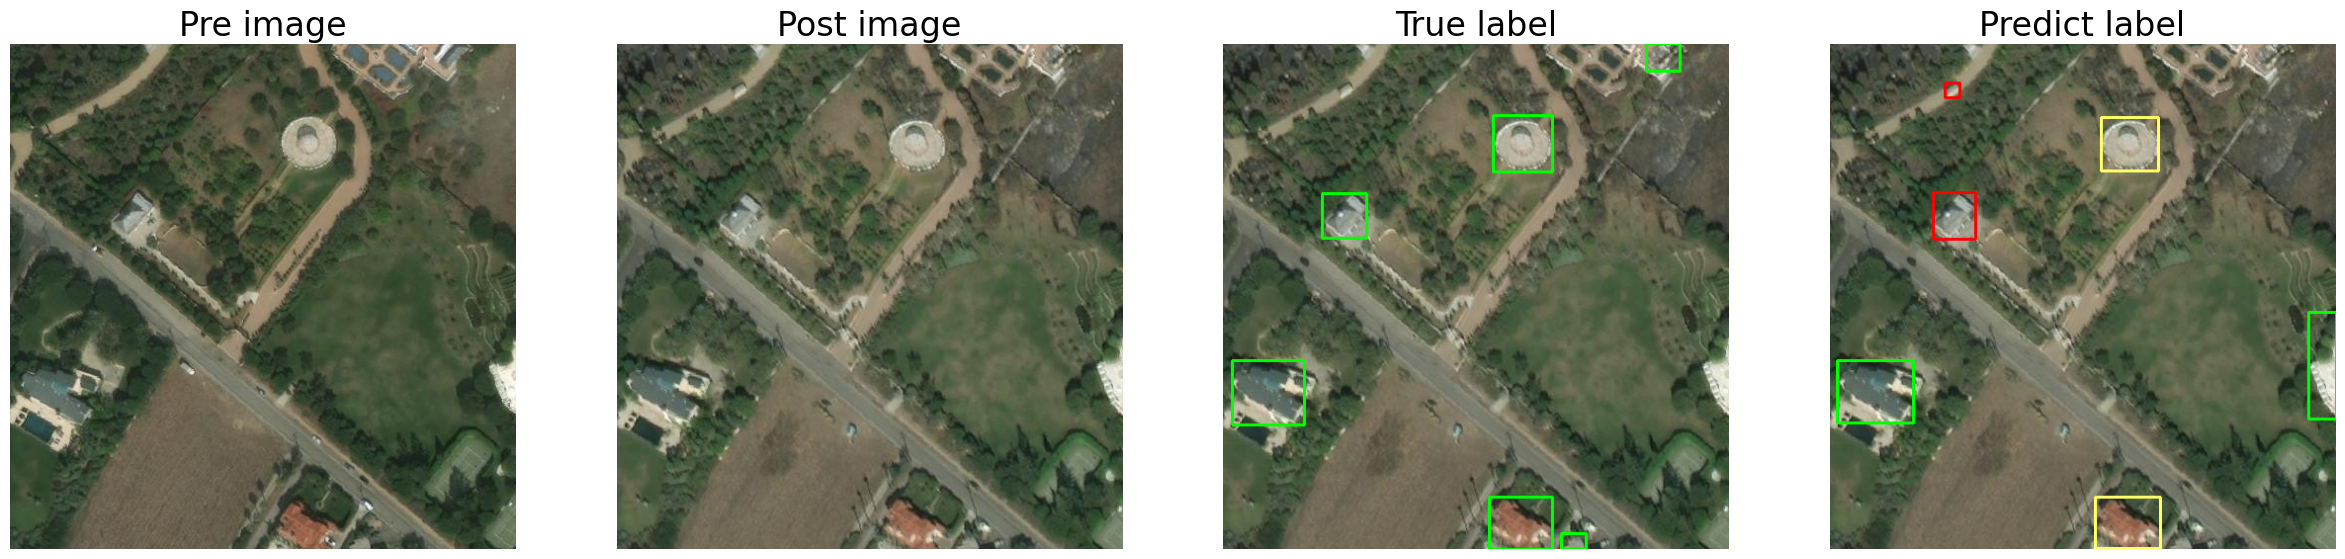

In [ ]:
num_images = 5

random.shuffle(post_images)
image_files = post_images[:num_images]

for image_file in image_files:
  result = detect_model.predict(source=image_file, show_labels=False, save=True, retina_masks=True)
  plot_images_with_boxes(image_file, result)